In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import time
import pickle

from statsmodels.tsa.seasonal import MSTL
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import QuantileRegressor, LinearRegression
from sklearn.metrics import mean_pinball_loss

import data_prepro as data_prepro

In [2]:
from importlib import reload
reload(data_prepro)

<module 'data_prepro' from 'c:\\Users\\ytl_c\\OneDrive\\Desktop\\22 ECON Hiwi\\2023_11-Karlsruhe-Bicycle-Data\\data_prepro.py'>

### Data Import

In [3]:
# import csv file
df = pd.read_csv('./data/2012-04-25_2024-01-25_KA_bike_weather.csv')

# change date col to datetime
df['date'] = pd.to_datetime(df['date'])
# set index as timestamp_CET but keep col
df.set_index('date', inplace=True, drop=False)
# rename date to timestamp_CET
df.rename(columns={'date': 'timestamp_CET'}, inplace=True)

print(df.info())
print(df.columns)
df.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4291 entries, 2012-04-25 to 2024-01-25
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   timestamp_CET   4291 non-null   datetime64[ns]
 1   bike_count      4291 non-null   float64       
 2   temperature     4291 non-null   float64       
 3   humidity        4291 non-null   float64       
 4   windspeed       4291 non-null   float64       
 5   wind_direction  4291 non-null   float64       
 6   visibility      4291 non-null   float64       
 7   precipitation   4291 non-null   float64       
 8   sun             4291 non-null   int64         
 9   windspeed_max   4291 non-null   float64       
 10  precip_indic    4291 non-null   float64       
 11  precip_type     4291 non-null   float64       
dtypes: datetime64[ns](1), float64(10), int64(1)
memory usage: 435.8 KB
None
Index(['timestamp_CET', 'bike_count', 'temperature', 'humidity', 'wind

,timestamp_CET,bike_count,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,precip_type
date,,,,,,,,,,,,
2024-01-21,2024-01-21,994.0,-1.500000,87.666667,1.587500,187.500000,14942.500000,0.0,191,7.7,0.0,0.0
2024-01-22,2024-01-22,3398.0,7.479167,76.791667,7.075000,223.750000,47245.416667,5.4,0,18.0,1.0,6.0
2024-01-23,2024-01-23,4427.0,8.358333,74.541667,7.250000,231.250000,38257.916667,0.5,164,16.6,0.5,3.0
2024-01-24,2024-01-24,4124.0,11.945833,72.291667,8.350000,234.583333,45765.833333,1.9,7,18.8,0.0,0.0
2024-01-25,2024-01-25,4594.0,9.366667,85.083333,3.345833,229.583333,23374.583333,1.0,220,7.5,0.0,0.0


### Run Simple Lin Reg for Feature Significance

In [60]:
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Function to train model and get predictions
def train_and_predict(X_train, y_train, X_test):
    model = sm.OLS(y_train, X_train).fit_regularized(method='elastic_net', alpha=0.1, L1_wt=1)
    y_pred = model.predict(X_test)
    return model, y_pred

df_dummy = data_prepro.create_dummy_df(df, holiday_method='separate', school_holidays_bw=True)
X1 = df_dummy.drop(columns=['timestamp_CET', 'bike_count'])
X1 = sm.add_constant(X1)
y = df_dummy['bike_count']

df_dummy = data_prepro.create_dummy_df(df, holiday_method='None', school_holidays_bw=False)
X2 = df_dummy.drop(columns=['timestamp_CET', 'bike_count'])
X2 = sm.add_constant(X2)

df_dummy = data_prepro.create_dummy_df(df[['timestamp_CET', 'bike_count']], holiday_method='separate', school_holidays_bw=True)
X3 = df_dummy.drop(columns=['timestamp_CET', 'bike_count'])
X3 = sm.add_constant(X3)

df_dummy = data_prepro.create_dummy_df(df[['timestamp_CET', 'bike_count']], holiday_method='None', school_holidays_bw=False)
X4 = df_dummy.drop(columns=['timestamp_CET', 'bike_count'])
X4 = sm.add_constant(X4)

# Split data into train and test sets for each model version
n_train = int(len(X1) * 0.95)
X_train1, X_test1 = X1[:n_train], X1[n_train:]
X_train2, X_test2 = X2[:n_train], X2[n_train:]
X_train3, X_test3 = X3[:n_train], X3[n_train:]
X_train4, X_test4 = X4[:n_train], X4[n_train:]

y_train, y_test = y[:n_train], y[n_train:]

# Train models and get predictions
model1, y_pred1 = train_and_predict(X_train1, y_train, X_test1)
model2, y_pred2 = train_and_predict(X_train2, y_train, X_test2)
model3, y_pred3 = train_and_predict(X_train3, y_train, X_test3)
model4, y_pred4 = train_and_predict(X_train4, y_train, X_test4)

In [63]:
# Compare Mean Squared Error on the test set
mse1 = mean_squared_error(y_test, y_pred1)
mse2 = mean_squared_error(y_test, y_pred2)
mse3 = mean_squared_error(y_test, y_pred3)
mse4 = mean_squared_error(y_test, y_pred4)

print(f'MSE Model 1: {mse1:.4f}')
print(f'MSE Model 2: {mse2:.4f} (no holiday)')
print(f'MSE Model 3: {mse3:.4f} (no weather)')
print(f'MSE Model 4: {mse4:.4f} (no holiday and weather)')

# set negative predictions to 0
y_pred1[y_pred1 < 0] = 0
y_pred2[y_pred2 < 0] = 0
y_pred3[y_pred3 < 0] = 0
y_pred4[y_pred4 < 0] = 0

print('= '*15)
# recalc MSE on the test set
mse1 = mean_squared_error(y_test, y_pred1)
mse2 = mean_squared_error(y_test, y_pred2)
mse3 = mean_squared_error(y_test, y_pred3)
mse4 = mean_squared_error(y_test, y_pred4)

print(f'MSE Model 1: {mse1:.4f}')
print(f'MSE Model 2: {mse2:.4f} (no holiday)')
print(f'MSE Model 3: {mse3:.4f} (no weather)')
print(f'MSE Model 4: {mse4:.4f} (no holiday and weather)')

MSE Model 1: 497586.3696
MSE Model 2: 803615.4087 (no holiday)
MSE Model 3: 745089.9421 (no weather)
MSE Model 4: 1004365.5398 (no holiday and weather)
= = = = = = = = = = = = = = = 
MSE Model 1: 442160.7224
MSE Model 2: 803308.1294 (no holiday)
MSE Model 3: 706771.9058 (no weather)
MSE Model 4: 1004365.5398 (no holiday and weather)


#### Plot

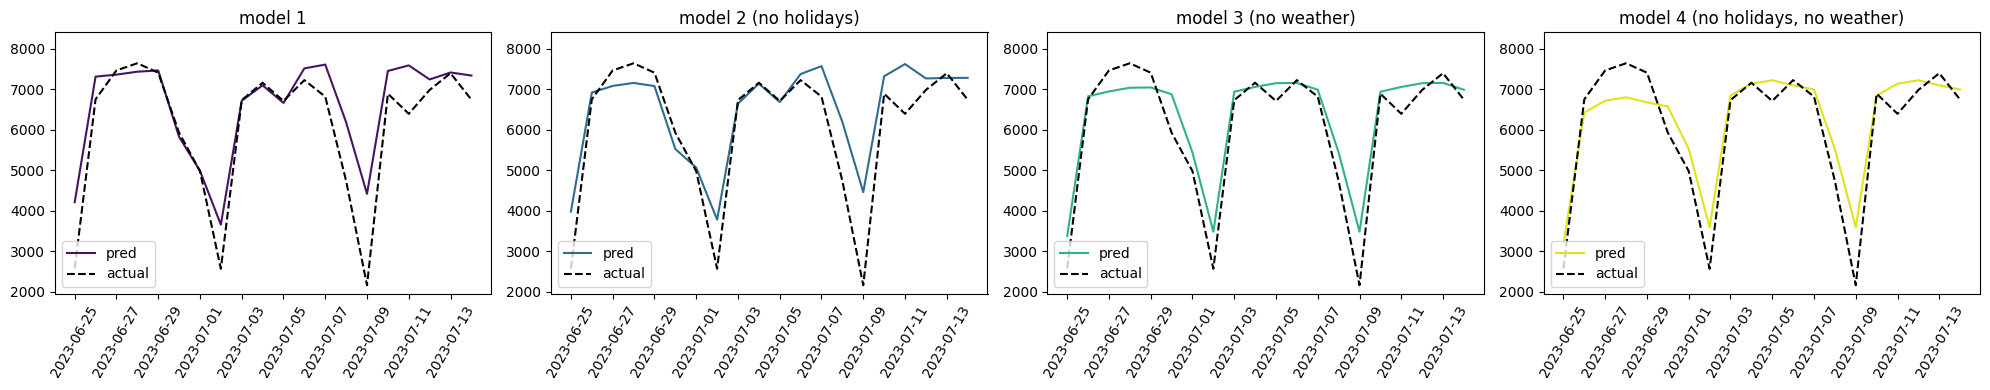

In [83]:
fig, axes = plt.subplots(1,4,figsize=(20, 4))

y_preds = [y_pred1, y_pred2, y_pred3, y_pred4]

# get min max
y_min = min([pred.min() for pred in (y_preds + [y_test])])
y_max = max([pred.max() for pred in (y_preds + [y_test])])

labels = ['model 1', 'model 2 (no holidays)', 'model 3 (no weather)', 'model 4 (no holidays, no weather)']
colors = plt.cm.viridis(np.linspace(0.05, 0.95, len(y_preds))) 

for idx, y_pred in enumerate(y_preds):
    ax = axes[idx]
    ax.plot(y_test.index, y_pred, label='pred', color=colors[idx])
    ax.plot(y_test.index, y_test, label='actual', ls='--', lw=1.5, color='k')

    ax.set_title(labels[idx])
    ax.legend(loc='lower left')
    # make x ticks rotate
    ax.tick_params(axis='x', rotation=60)
    ax.set_ylim(y_min*0.9, y_max*1.1)

plt.tight_layout()
plt.show()

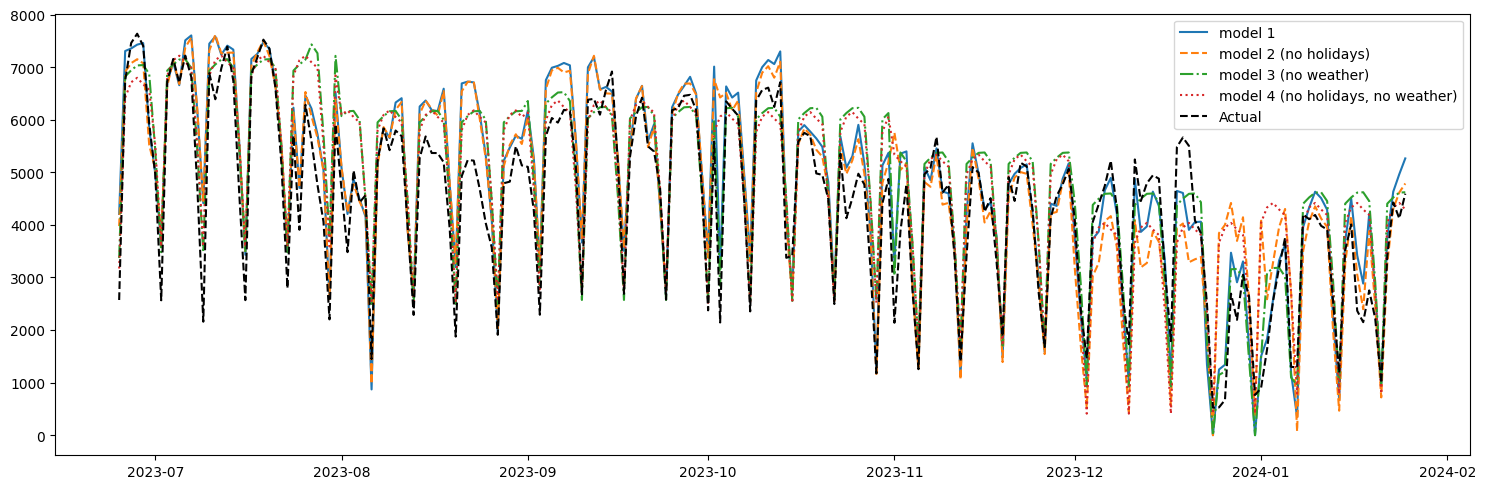

,Model 1,Model 2,Model 3,Model 4
const,5428.057413,5053.469498,4403.383864,4041.696113
temperature,75.907705,72.871461,NaN,NaN
humidity,-10.275036,-10.424873,NaN,NaN
windspeed,-62.521516,-56.494782,NaN,NaN
wind_direction,0.360594,0.221811,NaN,NaN
visibility,-0.005589,-0.007908,NaN,NaN
precipitation,-54.640128,-58.769325,NaN,NaN
sun,0.398380,0.371740,NaN,NaN
windspeed_max,-3.786632,-2.227520,NaN,NaN
precip_indic,-219.691747,-293.813210,NaN,NaN


In [67]:
# Plot predictions for comparison
plt.figure(figsize=(15, 5))

plt.plot(y_test.index, y_pred1, label='model 1')
plt.plot(y_test.index, y_pred2, ls='--', label='model 2 (no holidays)')
plt.plot(y_test.index, y_pred3, ls='-.', label='model 3 (no weather)')
plt.plot(y_test.index, y_pred4, ls=':', label='model 4 (no holidays, no weather)')

plt.plot(y_test.index, y_test, label='Actual', ls='--', lw=1.5, color='k')

plt.legend()
plt.tight_layout()
plt.show()

# Create a DataFrame to compare coefficients
coefficients_df = pd.DataFrame({
    'Model 1': model1.params,
    'Model 2': model2.params,
    'Model 3': model3.params,
    'Model 4': model4.params
}, index=X1.columns)

display(coefficients_df)

#### Rolling Window

= = = = = = = = = = = = = = = 
> fold 1 ...
= = = = = = = = = = = = = = = 
n_train: 4191
MSE Model 1: 420468.1890
MSE Model 2: 841502.1845 (no holiday)
MSE Model 3: 1285434.7127 (no weather)
MSE Model 4: 1525177.2018 (no holiday and weather)
= = = = = = = = = = = = = = = 
MSE Model 1: 420468.1890
MSE Model 2: 841502.1845 (no holiday)
MSE Model 3: 1285434.7127 (no weather)
MSE Model 4: 1525177.2018 (no holiday and weather)


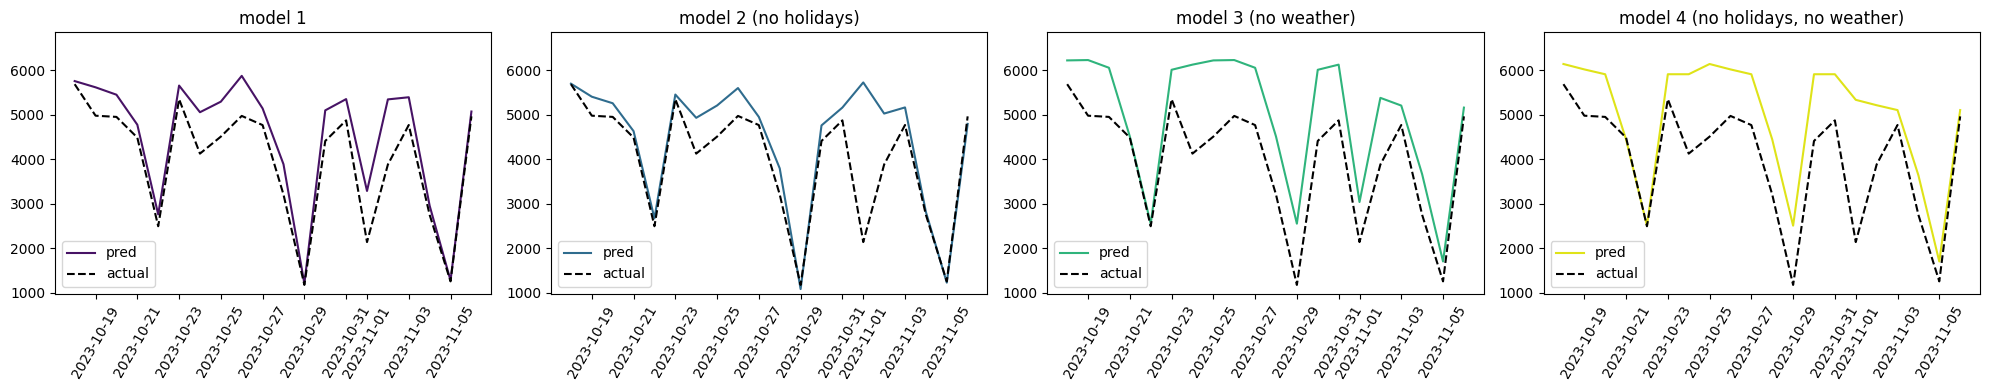

= = = = = = = = = = = = = = = 
> fold 2 ...
= = = = = = = = = = = = = = = 
n_train: 4211
MSE Model 1: 93952.8325
MSE Model 2: 108327.3809 (no holiday)
MSE Model 3: 429916.4511 (no weather)
MSE Model 4: 345655.9918 (no holiday and weather)
= = = = = = = = = = = = = = = 
MSE Model 1: 93952.8325
MSE Model 2: 108327.3809 (no holiday)
MSE Model 3: 429916.4511 (no weather)
MSE Model 4: 345655.9918 (no holiday and weather)


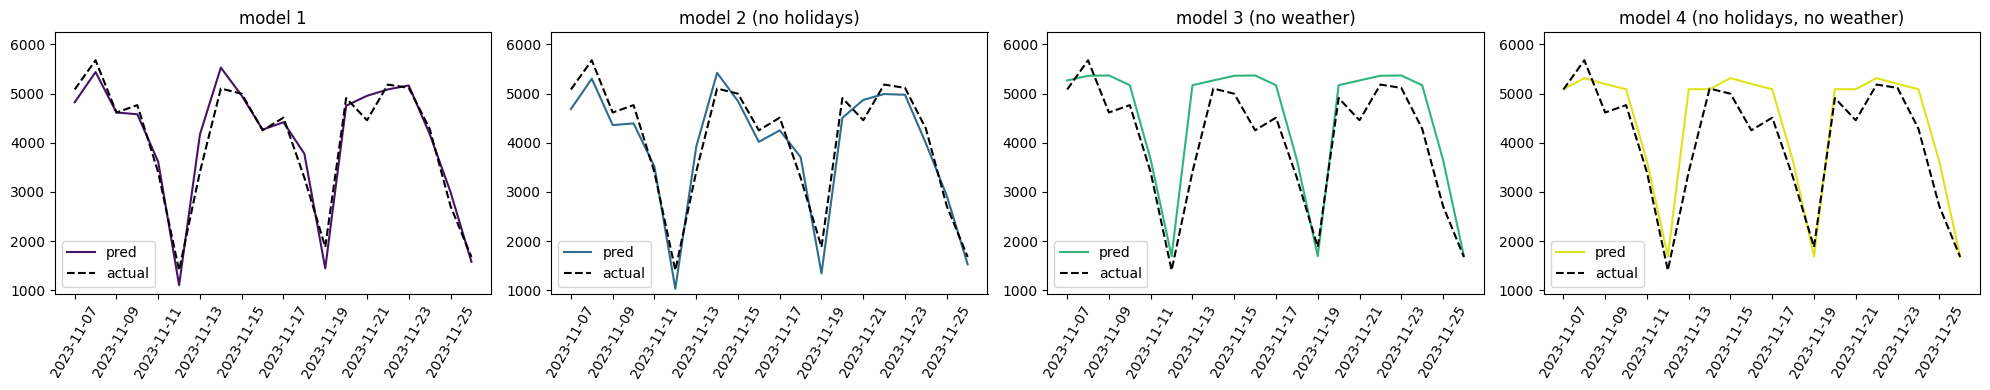

= = = = = = = = = = = = = = = 
> fold 3 ...
= = = = = = = = = = = = = = = 
n_train: 4231
MSE Model 1: 160280.3379
MSE Model 2: 854369.4855 (no holiday)
MSE Model 3: 174520.3021 (no weather)
MSE Model 4: 685871.6438 (no holiday and weather)
= = = = = = = = = = = = = = = 
MSE Model 1: 160280.3379
MSE Model 2: 854369.4855 (no holiday)
MSE Model 3: 174520.3021 (no weather)
MSE Model 4: 685871.6438 (no holiday and weather)


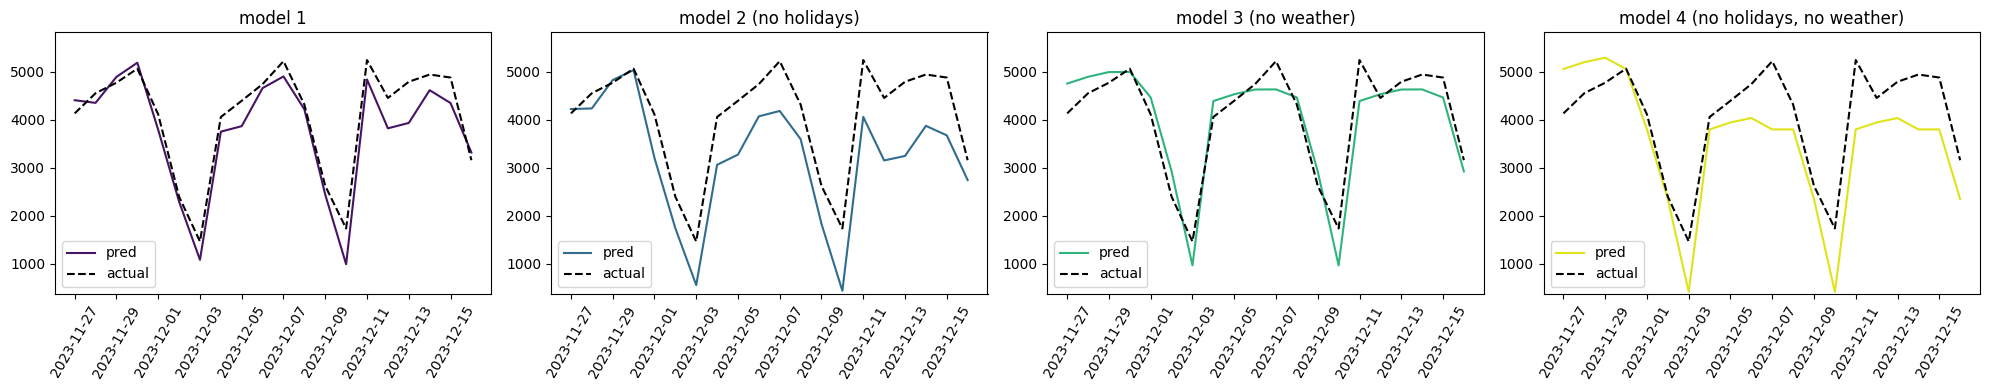

= = = = = = = = = = = = = = = 
> fold 4 ...
= = = = = = = = = = = = = = = 
n_train: 4251
MSE Model 1: 1111443.3539
MSE Model 2: 2677733.2491 (no holiday)
MSE Model 3: 1047004.9071 (no weather)
MSE Model 4: 2809736.0855 (no holiday and weather)
= = = = = = = = = = = = = = = 
MSE Model 1: 515070.4098
MSE Model 2: 2676516.2288 (no holiday)
MSE Model 3: 636830.5519 (no weather)
MSE Model 4: 2809736.0855 (no holiday and weather)


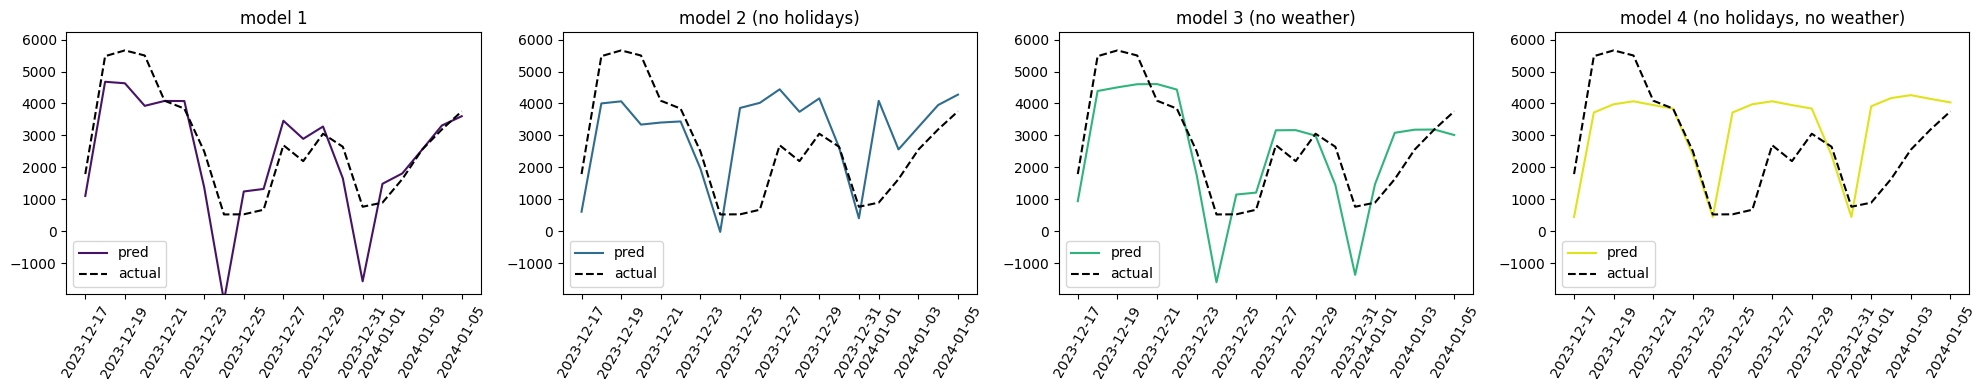

= = = = = = = = = = = = = = = 
> fold 5 ...
= = = = = = = = = = = = = = = 
n_train: 4271
MSE Model 1: 380778.9106
MSE Model 2: 356579.6398 (no holiday)
MSE Model 3: 1486807.0833 (no weather)
MSE Model 4: 631322.9131 (no holiday and weather)
= = = = = = = = = = = = = = = 
MSE Model 1: 380778.9106
MSE Model 2: 356579.6398 (no holiday)
MSE Model 3: 1486807.0833 (no weather)
MSE Model 4: 631322.9131 (no holiday and weather)


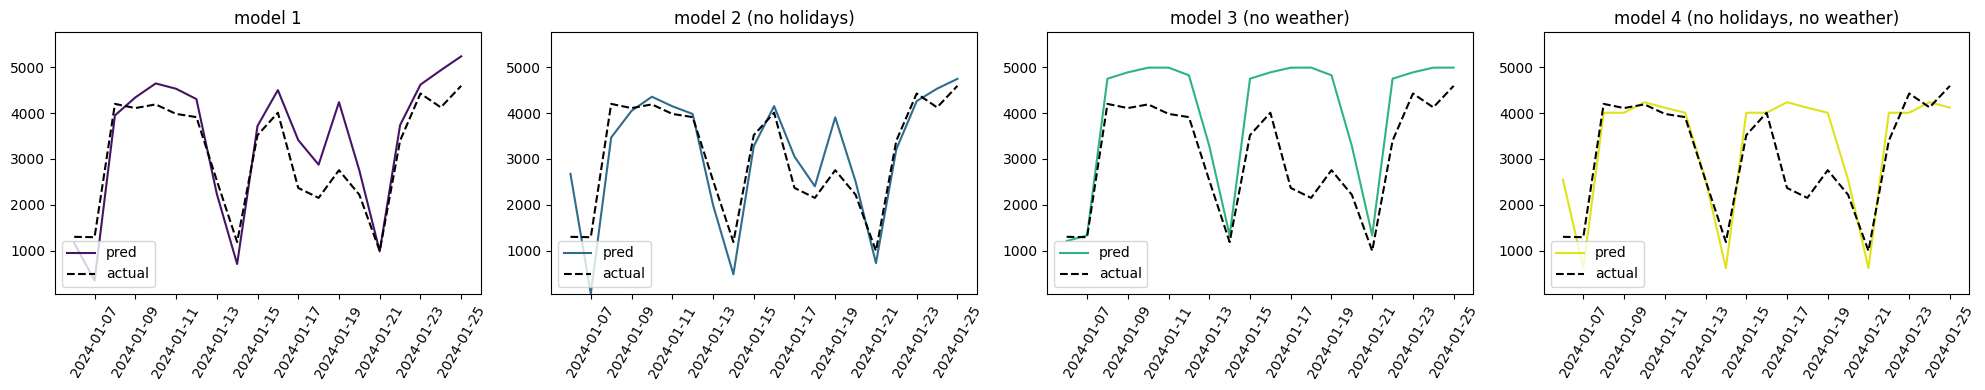

In [85]:
# Set rolling window parameters
test_size = 20
n_fold = 5

y = df_dummy['bike_count']

df_dummy = data_prepro.create_dummy_df(df, holiday_method='separate', school_holidays_bw=True)
X1 = df_dummy.drop(columns=['timestamp_CET', 'bike_count'])
X1 = sm.add_constant(X1)

df_dummy = data_prepro.create_dummy_df(df, holiday_method='None', school_holidays_bw=False)
X2 = df_dummy.drop(columns=['timestamp_CET', 'bike_count'])
X2 = sm.add_constant(X2)

df_dummy = data_prepro.create_dummy_df(df[['timestamp_CET', 'bike_count']], holiday_method='separate', school_holidays_bw=True)
X3 = df_dummy.drop(columns=['timestamp_CET', 'bike_count'])
X3 = sm.add_constant(X3)

df_dummy = data_prepro.create_dummy_df(df[['timestamp_CET', 'bike_count']], holiday_method='None', school_holidays_bw=False)
X4 = df_dummy.drop(columns=['timestamp_CET', 'bike_count'])
X4 = sm.add_constant(X4)

results = {}

# Iterate through folds
for fold_idx in range(n_fold):

    print('= '*15)
    print(f"> fold {fold_idx + 1} ...")
    print('= '*15)

    # Initialize dictionaries to store models, predictions, and true values for each method
    fold_results = {}

    # Split into train and test
    n_train = len(df) - test_size*(n_fold-fold_idx)
    print(f"n_train: {n_train}")

    # Split data into train and test sets for each model version
    X_train1, X_test1 = X1[:n_train], X1[n_train:n_train+test_size]
    X_train2, X_test2 = X2[:n_train], X2[n_train:n_train+test_size]
    X_train3, X_test3 = X3[:n_train], X3[n_train:n_train+test_size]
    X_train4, X_test4 = X4[:n_train], X4[n_train:n_train+test_size]

    y_train, y_test = y[:n_train], y[n_train:n_train+test_size]

    # Train models and get predictions
    model1, y_pred1 = train_and_predict(X_train1, y_train, X_test1)
    model2, y_pred2 = train_and_predict(X_train2, y_train, X_test2)
    model3, y_pred3 = train_and_predict(X_train3, y_train, X_test3)
    model4, y_pred4 = train_and_predict(X_train4, y_train, X_test4)

    # Compare Mean Squared Error on the test set
    mse1 = mean_squared_error(y_test, y_pred1)
    mse2 = mean_squared_error(y_test, y_pred2)
    mse3 = mean_squared_error(y_test, y_pred3)
    mse4 = mean_squared_error(y_test, y_pred4)

    print(f'MSE Model 1: {mse1:.4f}')
    print(f'MSE Model 2: {mse2:.4f} (no holiday)')
    print(f'MSE Model 3: {mse3:.4f} (no weather)')
    print(f'MSE Model 4: {mse4:.4f} (no holiday and weather)')

    # set negative predictions to 0
    y_pred1_nonneg = [0 if x < 0 else x for x in y_pred1]
    y_pred2_nonneg = [0 if x < 0 else x for x in y_pred2]
    y_pred3_nonneg = [0 if x < 0 else x for x in y_pred3]
    y_pred4_nonneg = [0 if x < 0 else x for x in y_pred4]

    print('= '*15)
    # recalc MSE on the test set
    mse1 = mean_squared_error(y_test, y_pred1_nonneg)
    mse2 = mean_squared_error(y_test, y_pred2_nonneg)
    mse3 = mean_squared_error(y_test, y_pred3_nonneg)
    mse4 = mean_squared_error(y_test, y_pred4_nonneg)

    print(f'MSE Model 1: {mse1:.4f}')
    print(f'MSE Model 2: {mse2:.4f} (no holiday)')
    print(f'MSE Model 3: {mse3:.4f} (no weather)')
    print(f'MSE Model 4: {mse4:.4f} (no holiday and weather)')

    # save
    fold_results['model1'] = model1
    fold_results['model2'] = model2
    fold_results['model3'] = model3
    fold_results['model4'] = model4

    fold_results['y_pred1'] = y_pred1
    fold_results['y_pred2'] = y_pred2
    fold_results['y_pred3'] = y_pred3
    fold_results['y_pred4'] = y_pred4

    fold_results['y_pred1_nonneg'] = y_pred1_nonneg
    fold_results['y_pred2_nonneg'] = y_pred2_nonneg
    fold_results['y_pred3_nonneg'] = y_pred3_nonneg
    fold_results['y_pred4_nonneg'] = y_pred4_nonneg

    fold_results['y_test'] = y_test

    # save to outer dict
    results[fold_idx] = fold_results

    # Plot predictions for comparison
    fig, axes = plt.subplots(1,4,figsize=(20, 4))

    y_preds = [y_pred1, y_pred2, y_pred3, y_pred4]

    # get min max
    y_min = min([pred.min() for pred in (y_preds + [y_test])])
    y_max = max([pred.max() for pred in (y_preds + [y_test])])

    labels = ['model 1', 'model 2 (no holidays)', 'model 3 (no weather)', 'model 4 (no holidays, no weather)']
    colors = plt.cm.viridis(np.linspace(0.05, 0.95, len(y_preds))) 

    for idx, y_pred in enumerate(y_preds):
        ax = axes[idx]
        ax.plot(y_test.index, y_pred, label='pred', color=colors[idx])
        ax.plot(y_test.index, y_test, label='actual', ls='--', lw=1.5, color='k')

        ax.set_title(labels[idx])
        ax.legend(loc='lower left')
        # make x ticks rotate
        ax.tick_params(axis='x', rotation=60)
        ax.set_ylim(y_min*0.9, y_max*1.1)

    plt.tight_layout()
    plt.show()


In [96]:
import pandas as pd

# Create DataFrames to store metrics
columns = ['Model', 'Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5', 'Average']
normal_metrics_df = pd.DataFrame(columns=columns)
nonneg_metrics_df = pd.DataFrame(columns=columns)

# Populate DataFrames with MSE values
for model_key in ['model1', 'model2', 'model3', 'model4']:
    normal_metrics_values = []
    nonneg_metrics_values = []

    for fold_idx in range(n_fold):
        fold_results = results[fold_idx]

        # Normal Predictions
        y_pred = fold_results[f'y_pred{model_key[-1]}']
        mse = mean_squared_error(fold_results['y_test'], y_pred)
        normal_metrics_values.append(mse)

        # Non-Negative Corrected Predictions
        y_pred_nonneg = fold_results[f'y_pred{model_key[-1]}_nonneg']
        mse_nonneg = mean_squared_error(fold_results['y_test'], y_pred_nonneg)
        nonneg_metrics_values.append(mse_nonneg)

    # Calculate average MSE
    avg_mse_normal = np.mean(normal_metrics_values)
    avg_mse_nonneg = np.mean(nonneg_metrics_values)

    # Add values to DataFrames
    normal_metrics_df.loc[len(normal_metrics_df)] = [model_key] + normal_metrics_values + [avg_mse_normal]
    nonneg_metrics_df.loc[len(nonneg_metrics_df)] = [model_key] + nonneg_metrics_values + [avg_mse_nonneg]

# Print DataFrames
print('= ' * 15 + " Normal Predictions " + '= ' * 15)
# round to 2 decimals
normal_metrics_df = normal_metrics_df.round(2)
display(normal_metrics_df)

print('= ' * 15 + " Non-Negative Corrected Predictions " + '= ' * 15)
nonneg_metrics_df = nonneg_metrics_df.round(2)
display(nonneg_metrics_df)


= = = = = = = = = = = = = = =  Normal Predictions = = = = = = = = = = = = = = = 


,Model,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Average
0,model1,420468.19,93952.83,160280.34,1111443.35,380778.91,433384.72
1,model2,841502.18,108327.38,854369.49,2677733.25,356579.64,967702.39
2,model3,1285434.71,429916.45,174520.30,1047004.91,1486807.08,884736.69
3,model4,1525177.20,345655.99,685871.64,2809736.09,631322.91,1199552.77


= = = = = = = = = = = = = = =  Non-Negative Corrected Predictions = = = = = = = = = = = = = = = 


,Model,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Average
0,model1,420468.19,93952.83,160280.34,515070.41,380778.91,314110.14
1,model2,841502.18,108327.38,854369.49,2676516.23,356579.64,967458.98
2,model3,1285434.71,429916.45,174520.30,636830.55,1486807.08,802701.82
3,model4,1525177.20,345655.99,685871.64,2809736.09,631322.91,1199552.77
